In [1]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
import mat73
from scipy.io import loadmat, savemat
import mne
#conda install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import random
from sklearn.cluster import KMeans
import os
os.chdir('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Interictal_Spike_Analysis/HUMAN/working_feat_extract_code/functions')
from ied_functions import *
import warnings
warnings.filterwarnings('ignore')

Identify the regions that we want to look at in order to establish some differences.

- SOZ vs. nonSOZ
- cortex vs non-cortex
- cortex vs. subcortical
- subcortical vs. subcortical
- depth vs. grid/strip

ALSO: atlas agnostic method in which we form clusters of about 5mm, group electrodes, and create heatmap of morphological feature.

FILES:
- all_ptids.csv (masterfile, contains r_id, hup_id, whichPts, ptname[same as hup_id])
- pt_ids.csv (raw r_id, hup_id)
- ptname_all.csv (whichPts, ptname [examples: ''HUP100''])
- SOZ_channels.csv (all SOZ electrodes for each pt - however only up to the whichPts = 1:119)
- RID.txt (all rids listed)

In [2]:
data_directory = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database'
ptnames = ['HUP105','HUP106','HUP107','HUP111']

In [3]:
spike, brain_df, ids = load_ptall(ptnames[0],data_directory)
print(ids)

['HUP105', 'sub-RID0101']


#### TO DO
- ~~what brain region do we want~~
- ~~add "-CAR" to the chlabels~~
- ~~find chlabel that match~~
- match it with spike.chlabel
- run amplitude/linelength to the values of these spikes
- First decision: only choose those that start with this channel, or run it for all values.
- then make a bar plot to graph
- run it for all patients.

In [4]:
pd.set_option('display.max_rows', 200)
brain_df


,Unnamed: 0,name,x,y,z,index,label
0,0,LA1-CAR,77.7201,131.6120,51.0434,1006.0,left entorhinal
1,1,LA2-CAR,72.6069,131.7390,50.8534,0.0,EmptyLabel
2,2,LA3-CAR,67.4461,131.5880,51.6281,0.0,EmptyLabel
3,3,LA4-CAR,62.3330,131.7140,51.4380,0.0,EmptyLabel
4,4,LAT1-CAR,71.6354,146.6290,42.1220,1006.0,left entorhinal
5,5,LAT2-CAR,65.3583,138.5490,37.7429,1007.0,left fusiform
6,6,LAT3-CAR,57.3199,132.7050,35.9230,1009.0,left inferior temporal
7,7,LAT4-CAR,48.5460,127.4160,38.3569,0.0,EmptyLabel
8,8,LF1-CAR,41.5512,93.2913,116.5260,0.0,EmptyLabel
9,9,LF2-CAR,35.1300,96.7684,108.8310,1031.0,left supramarginal


In [5]:
roi = ' left entorhinal '
roi_ch = brain_df.loc[brain_df['label']== roi]

display(roi_ch)
roi_chlist = np.array(roi_ch['name'])

,Unnamed: 0,name,x,y,z,index,label
0,0,LA1-CAR,77.7201,131.612,51.0434,1006.0,left entorhinal
4,4,LAT1-CAR,71.6354,146.629,42.1220,1006.0,left entorhinal
14,14,LH1-CAR,73.7539,126.223,47.4417,1006.0,left entorhinal


In [6]:
print(roi_chlist)

['LA1-CAR' 'LAT1-CAR' 'LH1-CAR']


In [7]:
idx_roich = []
for ch in roi_chlist:
    x = np.where(spike.chlabels[0][0] == ch)[0]
    idx_roich.append(x)


In [8]:
idx_roich = [x[0] for x in idx_roich]
idx_roich = [x+1 for x in idx_roich]
print(idx_roich)

#add 1, to get the true chlabel, which should be similar to the chlabel idx

[2, 6, 16]


In [9]:
counts,chs = hifreq_ch_spike(spike.select)
print(counts)

#use old function to generate counts, chs -> this will provide information of where the spike detector detected these channels of interest

[array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 28., 29., 30., 31., 32., 33.,
       34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46.,
       47., 48., 50., 51., 52., 53., 54., 55., 56., 57., 58., 60.]), [37, 48, 49, 13, 4, 10, 2, 9, 3, 2, 2, 1, 32, 11, 16, 20, 6, 9, 15, 1, 2, 6, 8, 18, 149, 165, 144, 56, 19, 12, 3, 1, 6, 8, 21, 14, 1, 2, 4, 6, 4, 11, 23, 11, 7, 2, 3, 1, 1, 1, 1]]


In [10]:
select_oi = []
for chroi in idx_roich:
    idx = np.where(chs == chroi)[0]
    select_oi.append(idx)
print(select_oi)

#select_oi finds where it is on our 1000 random spikes that we detected the channel !first!

[array([ 10,  46,  69,  85,  90, 100, 119, 150, 212, 222, 225, 231, 251,
       258, 260, 266, 279, 327, 330, 403, 472, 491, 563, 650, 690, 703,
       704, 705, 714, 739, 744, 756, 761, 811, 886, 902, 959]), array([ 29, 228, 672, 971]), array([  2,  43,  50,  54, 108, 136, 235, 248, 254, 334, 357, 383, 417,
       445, 497, 516, 540, 551, 558, 585, 670, 731, 735, 757, 778, 779,
       834, 844, 850, 864, 904, 910])]


In [11]:
#sanity check for the select_oi
#if we were right the spike.select should have the value 2, for the 10th idx
print(spike.select[10][1])
print(spike.select[29][1])
print(spike.select[2][1])

2.0
6.0
16.0


In [12]:
#np.size(select_oi[0]) + np.size(select_oi[1]) + np.size(select_oi[2])


In [ ]:
#select_oi = np.concatenate(select_oi)
select_oi = [int(x) for x in select_oi]
values_oi = []
for soi in select_oi:
    values_oi.append(spike.values[soi])

print(np.shape(values_oi))
#values_oi will contain thevalues that we require for our calculations. Essentially splitting it up.

In [15]:
def value_basis(spike, brain_df, roi):
    """
    Function that takes in all values, the DKT atlas dataframe, and a region of interest (ROI)
    returns a tailored, truncated list of the all the values given a specific ROI
    """
    roi_ch = brain_df.loc[brain_df['label']== roi] #creates truncated dataframe of ROI labels
    roi_chlist = np.array(roi_ch['name']) #converts DF to array

    #finds the index of where to find the channel
    idx_roich = []
    for ch in roi_chlist:
        x = np.where(spike.chlabels[0][0] == ch)[0]
        idx_roich.append(x)

    idx_roich = [x[0] for x in idx_roich]
    idx_roich = [x+1 for x in idx_roich]
    
    counts,chs = hifreq_ch_spike(spike.select)

    select_oi = []
    for chroi in idx_roich:
        idx = np.where(chs == chroi)[0]
        select_oi.append(idx)

    select_oi = np.concatenate(select_oi)
    select_oi = [int(x) for x in select_oi]
    values_oi = []
    for soi in select_oi:
        values_oi.append(spike.values[soi])

    based_values = values_oi
    
    return based_values

In [16]:
roi = ' left entorhinal '
based_values = value_basis(spike, brain_df, roi)

In [17]:
roi_ch = [2,6,16] #this is the name of the channel in matlab (use this when accessing spike.select)
idx_roich = [1, 5 ,15] #this is the actual idx of the channel in python

avg_waveforms = [0,0,0] #expect 3 waveforms for each roi_ch
ch1 = []
ch2 = []
ch3 = []
for spikess in based_values:
    spike_t = np.transpose(spikess)
    ch1.append((spike_t[idx_roich[0]]))
    ch2.append((spike_t[idx_roich[1]]))
    ch3.append((spike_t[idx_roich[2]]))
 
avg_waveforms[0] = np.nanmean(ch1,axis=0)
avg_waveforms[1] = (np.nanmean(ch2,axis=0))
avg_waveforms[2] = (np.nanmean(ch3,axis=0))

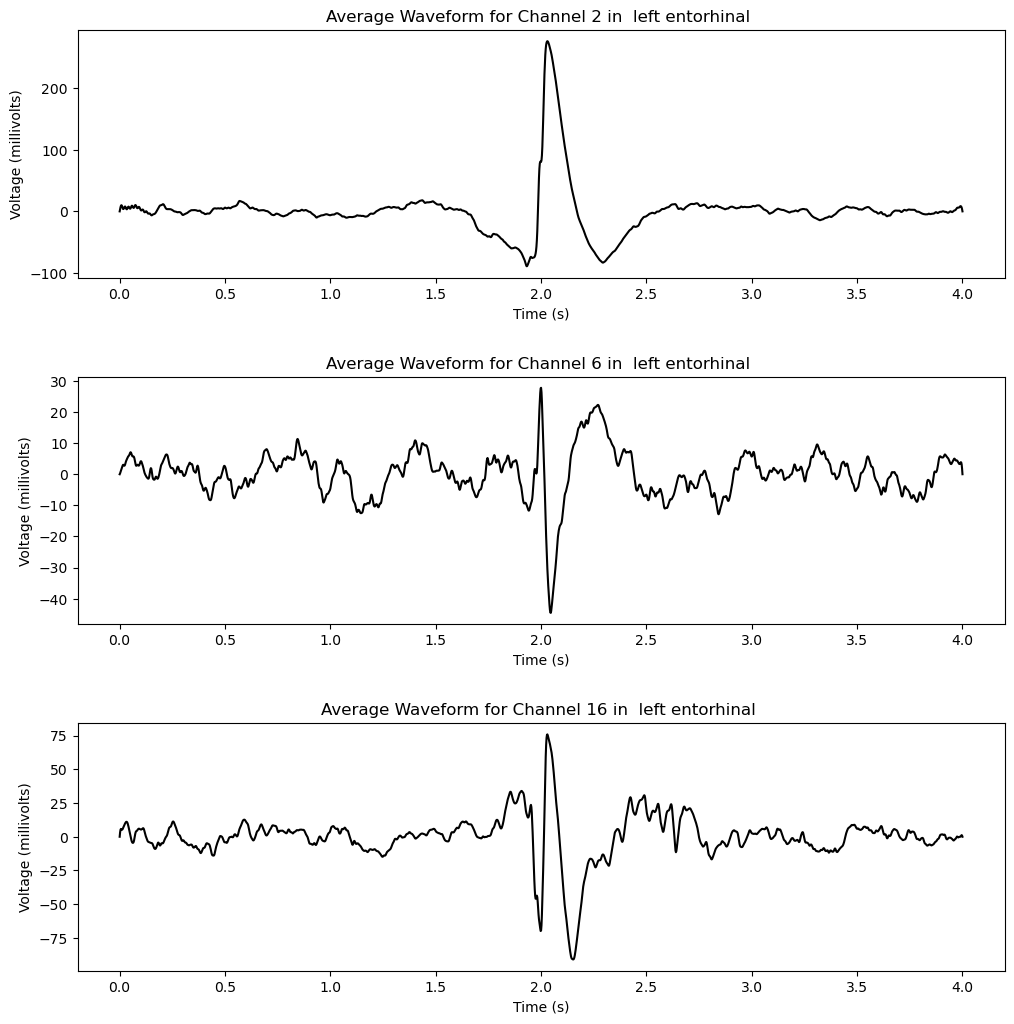

In [18]:
fig, axs = plt.subplots(len(avg_waveforms), 1, figsize=(10,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
time = np.linspace(0,4,2001)
for i in range(3):
    axs[i].plot(time, avg_waveforms[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {} in {}".format(int(roi_ch[i]),roi))

In [19]:
feats = create_feat_list(based_values)

In [ ]:
print(np.shape(feats)) # feats are amplitude, LL, and area of the spike
print(feats) #this will give you the feats for every single channel, in all 73 spike trains detected.

In [21]:
roi_ch = [2,6,16] #this is the name of the channel in matlab (use this when accessing spike.select)
idx_roich = [1, 5 ,15] #this is the actual idx of the channel in python

#basically gives you the feats for the target channel.
ch1_feats = []
ch2_feats = []
ch3_feats = []
for feat in feats:
    ch1_feats.append((feat[idx_roich[0]]))
    ch2_feats.append((feat[idx_roich[1]]))
    ch3_feats.append((feat[idx_roich[2]]))

In [22]:
print("Max Amplitude, LL, and Area")
print(ch1_feats[0])
print(ch2_feats[0])
print(ch3_feats[0])
#proof of concept for the layout

print(np.shape(ch1_feats))
print(np.shape(ch2_feats))
print(np.shape(ch3_feats))

Max Amplitude, LL, and Area
[396.91928407292517, 5505.812509198559, 73773.77222714911]
[86.93723077380048, 4714.453014012404, 46280.15499663287]
[323.74185126850597, 6460.730230685034, 86863.09274137266]
(73, 3)
(73, 3)
(73, 3)


In [23]:
#get a list of the all the L-ENTOR Amplitudes
amp_ch1 = [x[0] for x in ch1_feats]
amp_ch2 = [x[0] for x in ch2_feats]
amp_ch3 = [x[0] for x in ch3_feats]
lent_amp = [amp_ch1, amp_ch2, amp_ch3]
lent_amp = np.concatenate(lent_amp)

In [24]:
#get a list of the all the L-ENTOR Line Lengths
LL_ch1 = [x[1] for x in ch1_feats]
LL_ch2 = [x[1] for x in ch2_feats]
LL_ch3 = [x[1] for x in ch3_feats]
lent_LL = [LL_ch1, LL_ch2, LL_ch3]
lent_LL = np.concatenate(lent_LL)

In [25]:
#get a list of the all the L-ENTOR Areas
A_ch1 = [x[2] for x in ch1_feats]
A_ch2 = [x[2] for x in ch2_feats]
A_ch3 = [x[2] for x in ch3_feats]
lent_A = [A_ch1, A_ch2, A_ch3]
lent_A = np.concatenate(lent_A)

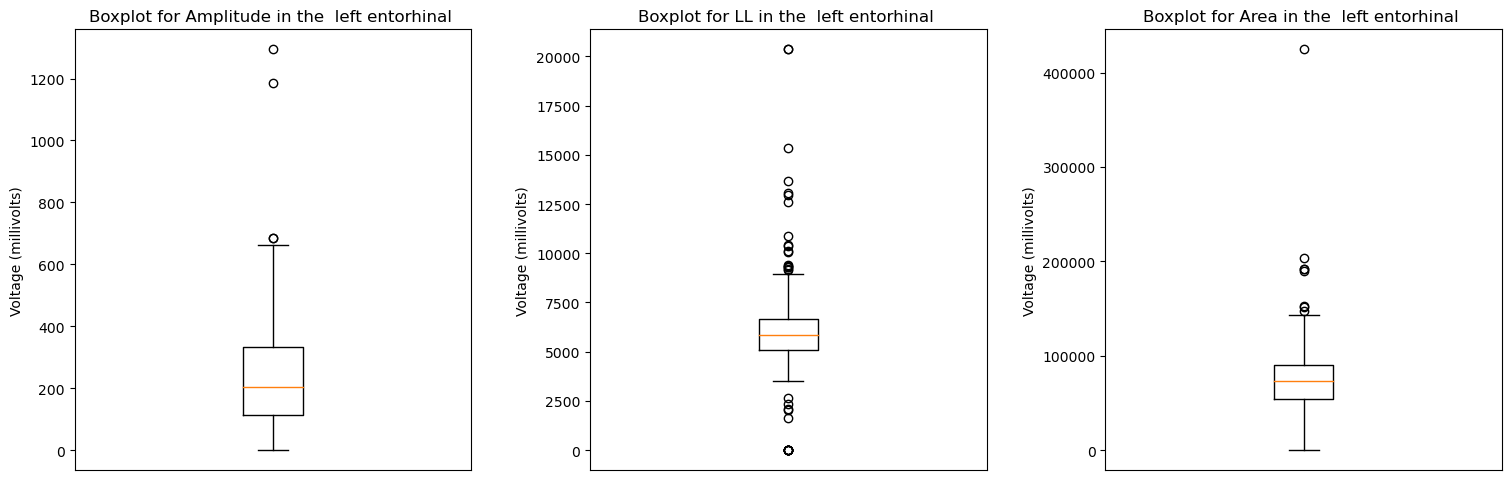

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
concat_feats = [lent_amp, lent_LL, lent_A]
labels = ['Amplitude', 'LL', 'Area']
for i in range(3):
    axs[i].boxplot(concat_feats[i], autorange=True)
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_title("Boxplot for {} in the {}".format(labels[i],roi))
    axs[i].get_xaxis().set_visible(False)


In [27]:
roi2 = [' left inferior temporal ', ' left middle temporal ', ' left superior temporal ']

test_roi2 = pd.DataFrame()
for roi in roi2:
    test_roi2 = test_roi2.append(brain_df[(brain_df['label'] == roi)])

def value_basis(spike, brain_df, roi):
    """
    Function that takes in all values, the DKT atlas dataframe, and a region of interest (ROI)
    returns a tailored, truncated list of the all the values given a specific ROI
    input: spike object, brain dataframe, roi list
    output: correlated values, channel number (matlab), indices of channels
    """
    roi_ch = pd.DataFrame()
    for x in roi:
        roi_ch = roi_ch.append(brain_df[(brain_df['label'] == x)])
        #roi_ch = roi_ch.concat([roi_ch, brain_df[(brain_df['label'] == x )]])

    #roi_ch = brain_df.loc[brain_df['label']== roi] #creates truncated dataframe of ROI labels
    roi_chlist = np.array(roi_ch['name']) #converts DF to array

    #finds the index of where to find the channel
    idx_roich = []
    for ch in roi_chlist:
        x = np.where(spike.chlabels[0][0] == ch)[0]
        idx_roich.append(x)

    idx_roich = [x[0] for x in idx_roich]
    chnum = [x+1 for x in idx_roich]

    counts,chs = hifreq_ch_spike(spike.select)

    select_oi = []
    for chroi in idx_roich:
        idx = np.where(chs == chroi)[0]
        select_oi.append(idx)

    select_oi = np.concatenate(select_oi)
    select_oi = [int(x) for x in select_oi]
    values_oi = []
    for soi in select_oi:
        values_oi.append(spike.values[soi])

    based_values = values_oi

    return based_values, chnum, idx_roich

# ^^^ this was added to value_basis into the .py file containing all my functions this works for importing MULTIPLE ROIs at once.

In [28]:
display(test_roi2)

,Unnamed: 0,name,x,y,z,index,label
6,6,LAT3-CAR,57.3199,132.7050,35.9230,1009.0,left inferior temporal
21,21,LMT4-CAR,44.6164,118.4240,45.2508,1009.0,left inferior temporal
31,31,LPT4-CAR,47.1067,102.6970,44.5096,1009.0,left inferior temporal
27,27,LP6-CAR,28.1950,91.5538,67.8318,1015.0,left middle temporal
13,13,LF6-CAR,28.4792,111.8730,72.9589,1030.0,left superior temporal
25,25,LP4-CAR,31.3376,72.4871,76.6425,1030.0,left superior temporal


In [29]:
#spike, brain_df, ids = load_ptall(ptnames[0],data_directory)
print(ids)
based_vals2, chnum2, idx_roich2 = value_basis(spike, brain_df, roi2)
print(idx_roich2) # want to use this idx to call on the spike object to align correctly
print(chnum2)

['HUP105', 'sub-RID0101']
[7, 22, 30, 26, 14, 24]
[8, 23, 31, 27, 15, 25]


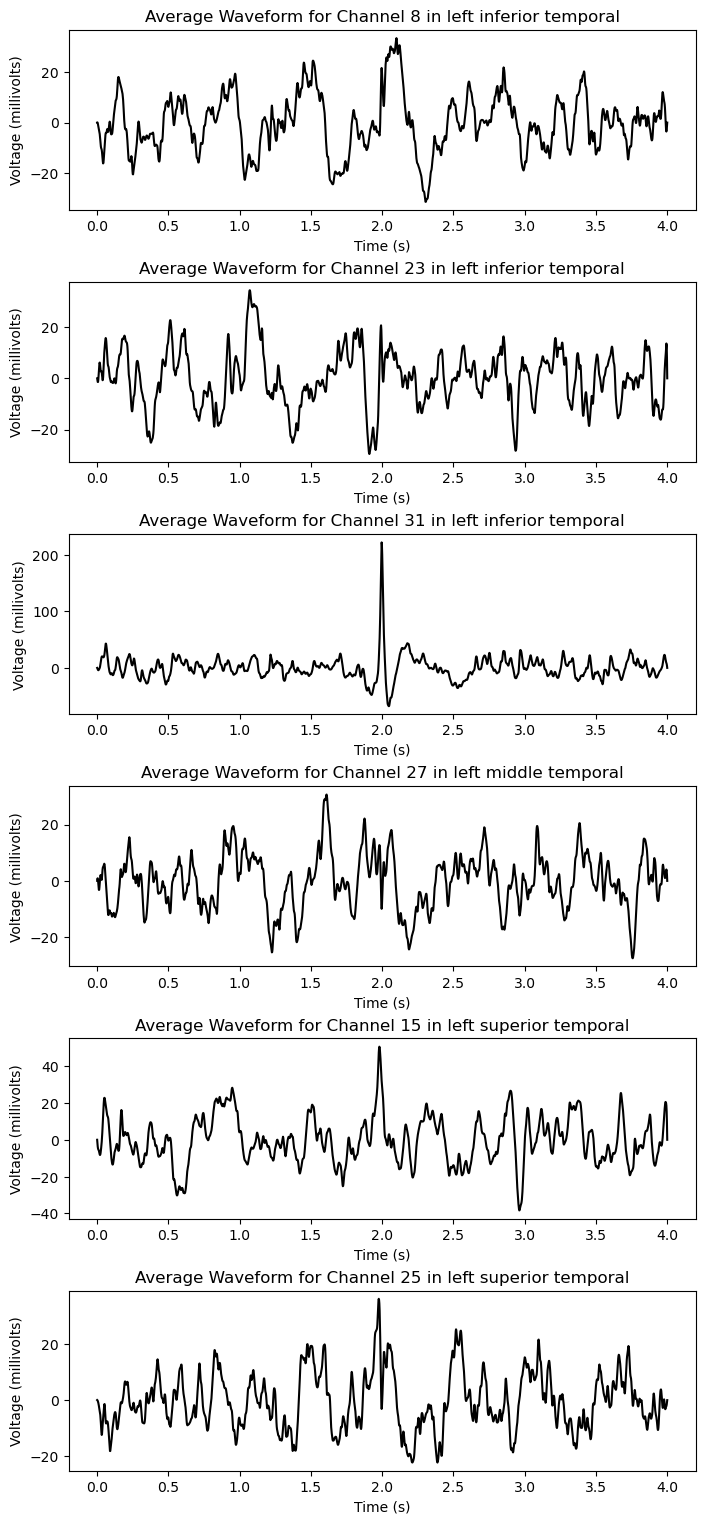

In [30]:
chnum2 #ch number
idx_roich2 # indicies

avg_waveforms2 = []#np.zeros(len(idx_roich2)) #expect 6 waveforms for each roi_ch
for i in range(len(idx_roich2)):
    ch = []
    for spikes2 in based_vals2:
        spike_t = np.transpose(spikes2)
        ch.append(spike_t[idx_roich2[i]])
    avg_waveforms2.append(np.nanmean(ch, axis=0))

roi_labels2 = ['left inferior temporal' ,'left inferior temporal','left inferior temporal', 'left middle temporal','left superior temporal','left superior temporal' ]
fig, axs = plt.subplots(len(avg_waveforms2), 1, figsize=(7,15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
time = np.linspace(0,4,2001)
for i in range(len(avg_waveforms2)):
    axs[i].plot(time, avg_waveforms2[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {} in {}".format(int(chnum2[i]),roi_labels2[i]))


In [31]:
feats2 = create_feat_list(based_vals2)

In [32]:
chnum2 #ch number
idx_roich2 # indicies

#basically gives you the feats for the target channel.
ch_feats2 = []
for i in range(len(idx_roich2)):
    for feat in feats2:
        ch_feats2.append(feat[idx_roich2[i]])

In [33]:
np.shape(ch_feats2)
amp_feat2 = [x[0] for x in ch_feats2]
ll_feat2 = [x[1] for x in ch_feats2]
area_feat2 = [x[2] for x in ch_feats2]
concat_feats2 = [amp_feat2, ll_feat2, area_feat2]

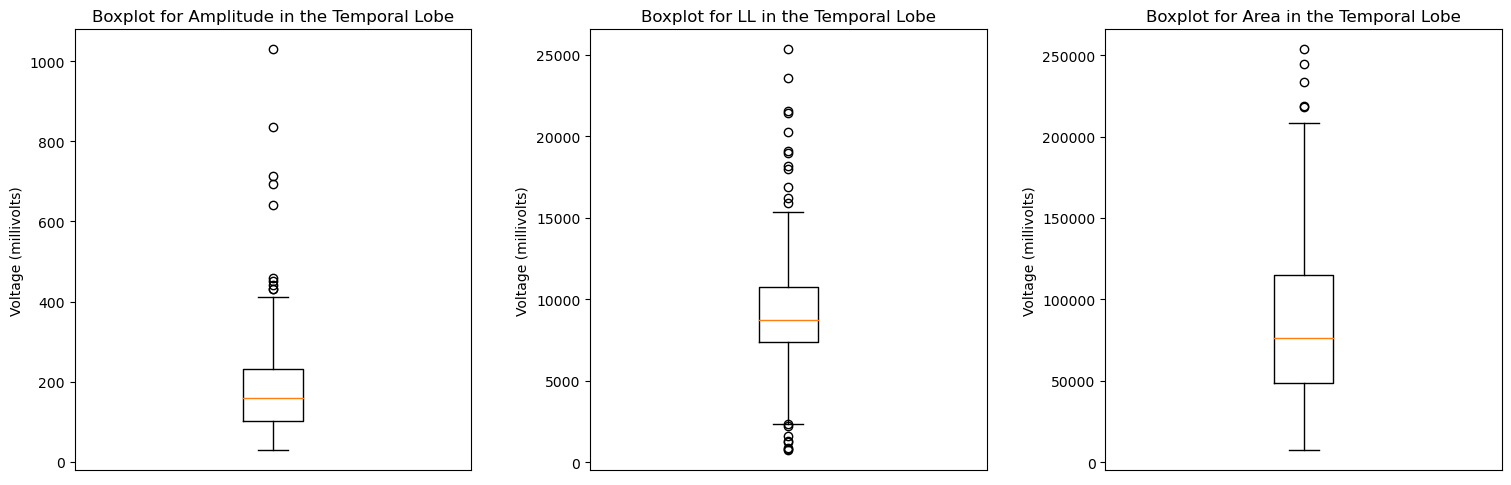

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
labels = ['Amplitude', 'LL', 'Area']
roi_concat = 'Temporal Lobe'
for i in range(3):
    axs[i].boxplot(concat_feats2[i], autorange=True)
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_title("Boxplot for {} in the {}".format(labels[i],roi_concat))
    axs[i].get_xaxis().set_visible(False)

In [ ]:
#Could say that their is a oscillatory nature of lateral temporal lobe spikes. 

In [35]:
display(brain_df)
roiL_mesial = [' left entorhinal ', ' left parahippocampal ']
roiL_lateral = [' left inferior temporal ', ' left fusiform ', ' left superior temporal ', ' left middle temporal ']

roiR_mesial = [' right entorhinal ', ' right parahippocampal ']
roiR_lateral = [' right inferior temporal ', ' right fusiform ', ' right superior temporal ', ' right middle temporal ']

,Unnamed: 0,name,x,y,z,index,label
0,0,LA1-CAR,77.7201,131.6120,51.0434,1006.0,left entorhinal
1,1,LA2-CAR,72.6069,131.7390,50.8534,0.0,EmptyLabel
2,2,LA3-CAR,67.4461,131.5880,51.6281,0.0,EmptyLabel
3,3,LA4-CAR,62.3330,131.7140,51.4380,0.0,EmptyLabel
4,4,LAT1-CAR,71.6354,146.6290,42.1220,1006.0,left entorhinal
5,5,LAT2-CAR,65.3583,138.5490,37.7429,1007.0,left fusiform
6,6,LAT3-CAR,57.3199,132.7050,35.9230,1009.0,left inferior temporal
7,7,LAT4-CAR,48.5460,127.4160,38.3569,0.0,EmptyLabel
8,8,LF1-CAR,41.5512,93.2913,116.5260,0.0,EmptyLabel
9,9,LF2-CAR,35.1300,96.7684,108.8310,1031.0,left supramarginal
